<a href="https://colab.research.google.com/github/ZRose100/Senior-Project/blob/main/Prioritization_CRF_and_Sentiment_Analysis_and_CCM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set-Up

In [ ]:
# Installations:
!pip install hdbscan
!pip install scikit-learn
!pip install sklearn-crfsuite
!pip install transformers
!pip install -q transformers torch torchvision
!pip install -q emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 39.2 MB/s eta 0:00:00


In [ ]:
# Imported Libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
import hdbscan
import nltk
from nltk.corpus import stopwords
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn_crfsuite
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.cm as cm

In [ ]:
# Import contact requests
requests = pd.read_excel('/content/updated_senior_source_data.xlsx')

# Rename column headers
requests = requests.rename(columns={'AREA WITH WHICH YOU NEED ASSISTANCE': 'ASSISTANCE TYPE',
                                    'Discovery Method': 'DISCOVERY METHOD'})

# Remove column
requests = requests.drop('HOW DID YOU HEAR ABOUT THE SENIOR SOURCE?', axis=1)

# Convert 'ENTRY DATE' to datetime if it's not already
requests['ENTRY DATE'] = pd.to_datetime(requests['ENTRY DATE'])

# Create TIME column from ENTRY DATE
requests['TIME'] = requests['ENTRY DATE'].dt.time

requests.head()

,NAME,PHONE,ZIP CODE,ASSISTANCE TYPE,AGE RANGE,COMMENTS,DISCOVERY METHOD,ENTRY DATE,MONTH,DAY,YEAR,Priority Score,TIME
0,Person1,Phone1,7624476244,Caregiver Support,65-70,In need of companionship to accompany me to t...,Referred,2024-10-01 21:59:34,October,1,2024,3,21:59:34
1,Person2,Phone2,75002,Employment Services,55-65,"Hello, my name is [NAME]\n\nI just relocated b...",Google/Internet Search,2024-10-02 08:49:06,October,2,2024,3,08:49:06
2,Person3,Phone3,77433,Financial Security,55-65,Need to speak with someone about getting Medi...,Google/Internet Search,2024-10-02 09:05:30,October,2,2024,1,09:05:30
3,Person4,Phone4,75228,Financial Security,70-80,I want to attend the Wills Clinic on 10/9,Social Media,2024-10-02 17:22:21,October,2,2024,1,17:22:21
4,Person5,Phone5,75201,Utilities Assistance,45-55,I am the Director of Community Engagement at t...,Attended an Event,2024-10-03 10:27:01,October,3,2024,0,10:27:01


# Comment Pre-Processing

In [ ]:
# Placeholders from Personal Identifier Scrubbing
placeholder_words = ['name','address','phone','email','website','location','company']

# Download Stopwords (common, irrelevant words) from NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Processes Text
def preprocess_text(text):
    text = text.lower()
    # Remove numbers
    # text = re.sub(r'\d+', '', text)
    text = re.sub(r'[0-9]+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords and placeholder words
    text = " ".join([word for word in text.split() if word not in stop_words and word not in placeholder_words])
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Convert 'COMMENTS' column to a string type
requests['COMMENTS'] = requests['COMMENTS'].astype(str)

# Preprocess the 'COMMENTS' column
requests['COMMENTS'] = requests['COMMENTS'].apply(preprocess_text)

# Sentiment Analysis

**Sentiment Levels:** negative, neutral, positive

In [ ]:
# Load model & tokenizer
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Labels from the model
labels = ['negative', 'neutral', 'positive']

# Run model on each comment
def get_sentiment(comment):
    text = comment
    #encoded_input = tokenizer(text, return_tensors='pt', truncation=True)
    encoded_input = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding=True,
        max_length=512  # Max for RoBERTa
    )
    output = model(**encoded_input)
    scores = softmax(output.logits.detach().numpy()[0])
    label = labels[np.argmax(scores)]
    confidence = scores[np.argmax(scores)]
    return label, confidence

# Apply to each row
results = requests['COMMENTS'].apply(get_sentiment)
requests['transformer_sentiment'] = results.apply(lambda x: x[0])
requests['transformer_confidence'] = results.apply(lambda x: x[1])

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Count the number of each sentiment
sentiment_counts = requests['transformer_sentiment'].value_counts()
print(sentiment_counts)

transformer_sentiment
neutral     4321
negative     587
positive      92
Name: count, dtype: int64


In [ ]:
display(requests[75:80])

,NAME,PHONE,ZIP CODE,ASSISTANCE TYPE,AGE RANGE,COMMENTS,DISCOVERY METHOD,ENTRY DATE,MONTH,DAY,YEAR,Priority Score,TIME,transformer_sentiment,transformer_confidence
75,Person76,Phone76,75126,Financial Security,55-65,sibling needs ongoing financial guidance,Social Media,2024-11-08 16:19:37,November,8,2024,1,16:19:37,neutral,0.807628
76,Person77,Phone77,10170,Request a Presentation,55-65,hi theseniorsourceorg owner found site quick q...,Social Media,2024-11-08 18:04:22,November,8,2024,0,18:04:22,positive,0.606768
77,Person78,Phone78,75219,Employment Services,55-65,good afternoon substitute teacher mother two g...,Social Media,2024-11-10 15:38:10,November,10,2024,0,15:38:10,positive,0.546109
78,Person79,Phone79,75181,Financial Security,55-65,im trying get help gas bill water bill dont wa...,Referred,2024-11-11 15:44:03,November,11,2024,1,15:44:03,negative,0.553505
79,Person80,Phone80,75074,Utilities Assistance,65-70,hello currently dv shelter move apartment via ...,Referred,2024-11-12 07:04:47,November,12,2024,2,07:04:47,positive,0.580790


# CRF Constrained Conditional Model

**Priority Levels:** 0, 1, 2, 3

**Constraints:** Features (columns) in  data that influence priority scores. Define rules that relate these features to priority levels.

*For example, you might specify:*

*   If 'ASSISTANCE TYPE' is 'Financial Assistance' then priority should be 3.
*   If 'DISCOVERY METHOD' is 'Referral' and 'TIME' is between 9:00 AM and 5:00 PM, then priority should be 1.

**Conditional Random Field (CRF):** A CRF is a probabilistic graphical model well-suited for structured prediction tasks. It can incorporate constraints by defining feature functions that reflect your rules.

In [ ]:
# Define features and labels
X = requests.drop('Priority Score', axis=1).astype(str)
y = requests['Priority Score'].astype(str)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train:\n", X_train.head())
print("y_train:\n", y_train.head())
print("X_test:\n", X_test.head())
print("y_test:\n", y_test.head())

X_train:
             NAME      PHONE ZIP CODE  \
4227  Person4228  Phone4228    78216   
4676  Person4677  Phone4677    75150   
800    Person801   Phone801    75159   
3671  Person3672  Phone3672    76244   
4193  Person4194  Phone4194    76086   

                                        ASSISTANCE TYPE AGE RANGE  \
4227                                 Financial Security     21-45   
4676                            Guardianship Protection     55-65   
800                             Guardianship Protection       80+   
3671                            Volunteer Opportunities     21-45   
4193  Nursing Home/Assisted Living Facility Issues a...     45-55   

                                               COMMENTS   DISCOVERY METHOD  \
4227  struggling financially desperate help section ...           Referred   
4676          need immediate guidance guardianship laws      E-News/E-Mail   
800   seeking occasional help establishing guardians...        Direct Mail   
3671  desperate critic

In [ ]:
urgency_words = ["urgent", "crisis", "accident", "danger", "disaster", "hardship", "bankruptcy", "difficulty", "emergency","termination","disconnect"]

# Define feature functions to capture constraints
def feature_func1(x, i, y_pred):
    # High priority for assistance types that indicate urgency
    if x[i][0]['ASSISTANCE TYPE'] == 'Financial Assistance' or x[i][0]['ASSISTANCE TYPE'] == 'Utilities Assistance' or x[i][0]['ASSISTANCE TYPE'] == 'Financial Security':
        return '3'
    # High priority for words indicating emergencies or time sensitive
    elif any(word in x[i][0]['COMMENTS'] for word in urgency_words):
        return '3'
    # Medium priority for negative sentiment
    elif x[i][0]['transformer_sentiment'] == 'negative' and float(x[i][0]['transformer_confidence']) > 0.75:
        return '2'
    # Low priority for very long (scam) or short (can not handle) comments
       # Number is based on 'COMMENTS' column characters not words
    elif len(x[i][0]['COMMENTS']) < 20 or len(x[i][0]['COMMENTS']) > 1200:
        return '0'
    # Low priority for links as it can indicate a scams
    elif 'https://' in x[i][0]['COMMENTS']:
        return '0'
    return y_pred[i]

# Convert X_train and X_test to the required format
X_train_list = [[record] for record in X_train.to_dict(orient='records')]  # Convert X_train to a list of lists
X_test_list = [[record] for record in X_test.to_dict(orient='records')]  # Convert X_test to a list of lists

# Create CRF model
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)

# Train the model using the converted X_train_list
crf.fit(X_train_list, y_train)

# Predict priority scores using the converted X_test_list
y_pred = crf.predict(X_test_list)

# Iterate through X_test_list and apply constraints
for i, row in enumerate(X_test_list):
    if i < len(X_test_list):
        feature_value = feature_func1(X_test_list, i, y_pred)
        y_pred[i] = feature_value  # Changed to reflect updated usage of y_pred

In [ ]:
X_test_df = pd.DataFrame([d[0] for d in X_test_list])
# y_pred is a 2D array, flatten it to 1D before assigning to a DataFrame column
X_test_df['predicted_priority'] = y_pred.flatten()
display(X_test_df)

,NAME,PHONE,ZIP CODE,ASSISTANCE TYPE,AGE RANGE,COMMENTS,DISCOVERY METHOD,ENTRY DATE,MONTH,DAY,YEAR,TIME,transformer_sentiment,transformer_confidence,predicted_priority
0,Person1502,Phone1502,75227,Request a Speaker,65-70,library seeking urgent speaker volunteering,Drive by facility/signs,1970-01-01 00:00:00.000045620,November,24,2024,00:00:00.000045,neutral,0.836379,3
1,Person2587,Phone2587,75036,Caregiver Support,70-80,grandmother desperate ongoing help transportat...,Unknown,1970-01-01 00:00:00.000045627,December,1,2024,00:00:00.000045,neutral,0.59693027,3
2,Person2654,Phone2654,75043,Volunteer Opportunities,21-45,suggest urgent volunteer opportunities,Google/Internet Search,1970-01-01 00:00:00.000045694,February,6,2025,00:00:00.000045,neutral,0.57315105,3
3,Person1056,Phone1056,75023,Utilities Assistance,55-65,requires immediate assistance water bill,Direct Mail,1970-01-01 00:00:00.000045609,November,13,2024,00:00:00.000045,neutral,0.63446826,3
4,Person706,Phone706,75044,Donations and Giving to The Senior Source,55-65,could use donate food occasional senior support,Unknown,1970-01-01 00:00:00.000045742,March,26,2025,00:00:00.000045,neutral,0.6011313,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Person4712,Phone4712,75228,Media Inquiries,80+,planning feature piece seeking urgent input,Unknown,1970-01-01 00:00:00.000045626,November,30,2024,00:00:00.000045,neutral,0.8782288,3
996,Person2314,Phone2314,77433,Media Inquiries,65-70,feature immediate services podcast segment,In Service Industry,1970-01-01 00:00:00.000045598,November,2,2024,00:00:00.000045,neutral,0.880357,0
997,Person3215,Phone3215,75227,Media Inquiries,65-70,feature immediate services podcast segment,E-News/E-Mail,1970-01-01 00:00:00.000045660,January,3,2025,00:00:00.000045,neutral,0.880357,0
998,Person2733,Phone2733,94110,Nursing Home/Assisted Living Facility Issues a...,21-45,could use critical advice assisted living options,Unknown,1970-01-01 00:00:00.000045682,January,25,2025,00:00:00.000045,neutral,0.7699588,3


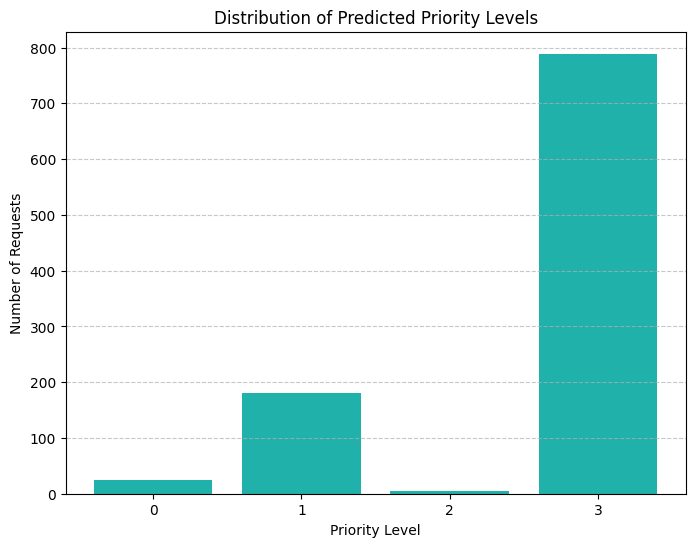

In [ ]:
# Assuming y_pred contains your predicted priority levels
priority_levels, counts = np.unique(y_pred, return_counts=True)

plt.figure(figsize=(8, 6))  # Adjust figure size if needed
plt.bar(priority_levels, counts, color='lightseagreen')

plt.xlabel('Priority Level')
plt.ylabel('Number of Requests')
plt.title('Distribution of Predicted Priority Levels')

# Customize x-axis ticks if needed
plt.xticks(priority_levels)

plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability

plt.show()

In [ ]:
# Generate Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.53      0.68        43
           1       0.81      0.41      0.55       353
           2       0.20      0.03      0.05        36
           3       0.68      0.95      0.79       568

    accuracy                           0.71      1000
   macro avg       0.65      0.48      0.52      1000
weighted avg       0.72      0.71      0.68      1000



Overall Accuracy: 0.709


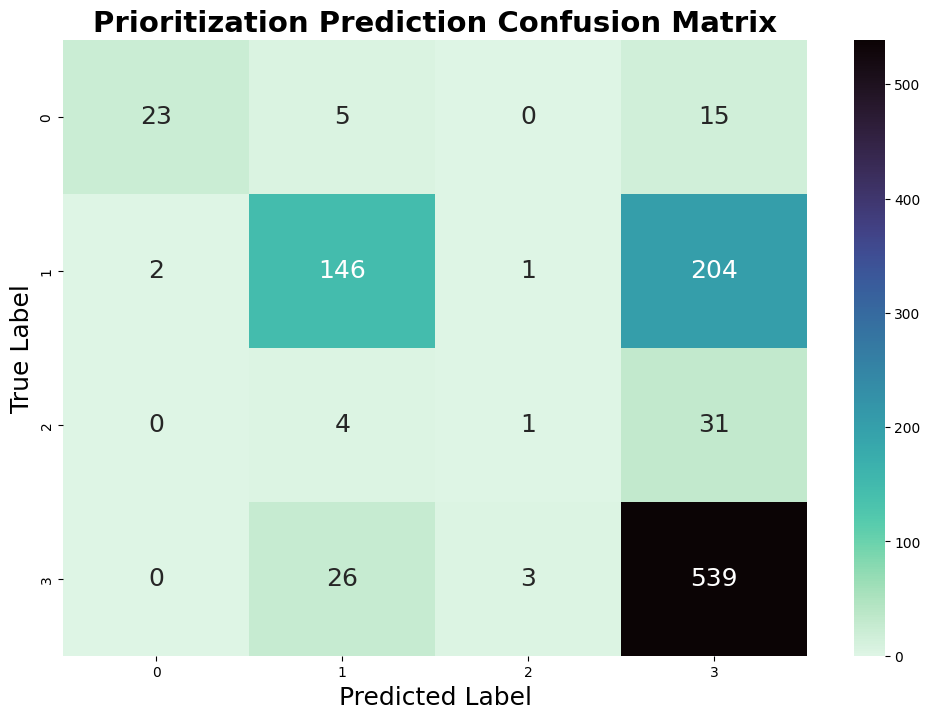

In [ ]:
# Accuracy
print("Overall Accuracy:", accuracy_score(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap='mako_r',
            annot_kws={"size": 18})
plt.xlabel('Predicted Label', fontsize=18)
plt.ylabel('True Label', fontsize=18)
plt.title('Prioritization Prediction Confusion Matrix', fontweight='bold',fontsize=21)
plt.show()

<ipython-input-36-c596906c044b>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('mako', num_metrics)  # Replace 'viridis' with your preferred colormap


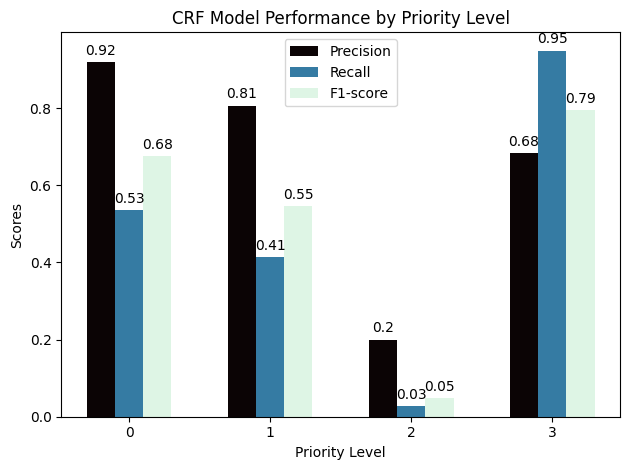

In [ ]:
# Accuracy Metric Distribution
report = classification_report(y_test, y_pred, output_dict=True)
priority_levels = list(report.keys())[:-3]  # Exclude 'accuracy', 'macro avg', 'weighted avg'
metrics = ['precision', 'recall', 'f1-score']

x = np.arange(len(priority_levels))  # the label locations
width = 0.2  # the width of the bars

# Choose colormap and get a range of colors
num_metrics = len(metrics)  # Number of metrics (precision, recall, f1-score)
colormap = cm.get_cmap('mako', num_metrics)  # Replace 'viridis' with your preferred colormap
colors = [colormap(i) for i in range(num_metrics)]

fig, ax = plt.subplots()

# Apply colors to the bars and get bar containers
rects1 = ax.bar(x - width, [report[level]['precision'] for level in priority_levels], width, label='Precision', color=colors[0])
rects2 = ax.bar(x, [report[level]['recall'] for level in priority_levels], width, label='Recall', color=colors[1])
rects3 = ax.bar(x + width, [report[level]['f1-score'] for level in priority_levels], width, label='F1-score', color=colors[2])

# Function to add labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height,2)),  # Format the number (e.g., round to 2 decimals)
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Add labels to each set of bars
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
ax.set_xlabel('Priority Level')
ax.set_ylabel('Scores')
ax.set_title('CRF Model Performance by Priority Level')
ax.set_xticks(x)
ax.set_xticklabels(priority_levels)
ax.legend()

fig.tight_layout()
plt.show()